In [42]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

## Preprocessing

In [43]:
df = pd.read_csv('wine.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   object 
dtypes: float64(11), object(1)
memory usage: 150.0+ KB


In [44]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


<Axes: xlabel='quality', ylabel='Count'>

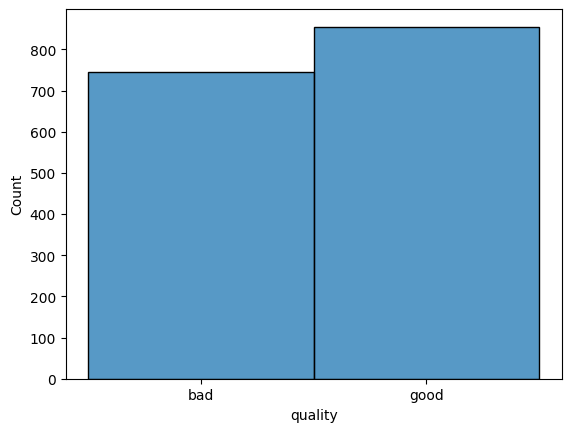

In [45]:
sns.histplot(df, x="quality")

In [46]:
df['quality'] = df['quality'].map({"bad":0,"good":1})
df['quality'].value_counts(normalize=True)

quality
1    0.534709
0    0.465291
Name: proportion, dtype: float64

In [47]:
X = torch.from_numpy(df.drop('quality', axis=1).to_numpy()).to(torch.float32)
y = torch.from_numpy(df['quality'].to_numpy()).to(torch.float32)
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=4)

In [48]:
print(f"Train: {X_train.shape}, valid: {X_valid.shape[0]}")

Train: torch.Size([1279, 11]), valid: 320


In [49]:
y_train

tensor([0., 1., 0.,  ..., 0., 0., 1.])

In [50]:
BATCH_SIZE=X_train.shape[0]

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = torch.utils.data.TensorDataset(X_valid, y_valid)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [51]:
class MyModel(torch.nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()
        self.linear1 = torch.nn.Linear(11,64)
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(64, 32)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(32, 1)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        x = self.sigmoid(x)


        return x.squeeze()

mymodel = MyModel()

In [52]:
print(mymodel)

MyModel(
  (linear1): Linear(in_features=11, out_features=64, bias=True)
  (activation1): ReLU()
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (activation2): ReLU()
  (linear3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [53]:
print('\n\nLinear Layer 2 params:')
for param in mymodel.linear2.parameters():
    print(param)



Linear Layer 2 params:
Parameter containing:
tensor([[ 0.0504,  0.1183,  0.1000,  ..., -0.0721,  0.0233,  0.0723],
        [ 0.1151, -0.0083, -0.1086,  ...,  0.0338,  0.1017, -0.0401],
        [ 0.0123, -0.0888,  0.0281,  ..., -0.0214, -0.0678,  0.1020],
        ...,
        [-0.0692, -0.0308, -0.0023,  ...,  0.0953,  0.0553,  0.0252],
        [-0.0767, -0.0482, -0.0612,  ..., -0.0657, -0.1170,  0.0529],
        [ 0.0341, -0.0964,  0.0221,  ...,  0.0353, -0.0995,  0.1034]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0992, -0.0535,  0.0528, -0.0542, -0.0768, -0.0628,  0.0263, -0.0018,
        -0.0015,  0.0080, -0.0367, -0.0471, -0.0436,  0.0236,  0.0953,  0.0974,
        -0.1007, -0.0762, -0.0253,  0.1164, -0.0547,  0.0129, -0.1061,  0.0269,
        -0.0647,  0.0334,  0.0818,  0.0827, -0.0120,  0.0035,  0.0520,  0.1186],
       requires_grad=True)


In PyTorch, the nn.Linear module's weights are initialized by default using a method "He initialization.

In [54]:
NUM_EPOCH = 1000

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(mymodel.parameters(), lr=0.1)

train_loss_list = []
valid_loss_list = []
accuracy_list = []

min_valid_loss = np.inf

for epoch in range(NUM_EPOCH):
    train_loss = 0.0
    mymodel.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        pred = mymodel(inputs)

        loss = loss_fn(pred,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss_list.append(train_loss/len(train_loader))

    mymodel.eval()
    valid_loss, correct = 0, 0
    size = len(valid_loader.dataset)
    with torch.no_grad():
        for inputs, labels in valid_loader:
            pred = mymodel(inputs)
            loss = loss_fn(pred,labels)
            valid_loss += loss.item()
            binary_pred = (pred >= 0.5).float()
            correct += (binary_pred==labels).sum().item()
        correct /= size
        valid_loss/=len(valid_loader)
        accuracy_list.append(correct)
        valid_loss_list.append(valid_loss)


    print(f"Epoch {epoch}: train_loss = {train_loss_list[epoch]}, valid_loss= {valid_loss_list[epoch]}, accuracy= {correct*100}")

   
    


Epoch 0: train_loss = 0.6786924004554749, valid_loss= 1.6285927295684814, accuracy= 49.6875
Epoch 1: train_loss = 1.7433173656463623, valid_loss= 4.869925022125244, accuracy= 50.31250000000001
Epoch 2: train_loss = 4.55788516998291, valid_loss= 0.7162349820137024, accuracy= 45.9375
Epoch 3: train_loss = 0.7090427875518799, valid_loss= 0.6966702342033386, accuracy= 45.0
Epoch 4: train_loss = 0.6939703226089478, valid_loss= 0.6945050954818726, accuracy= 51.87500000000001


Epoch 5: train_loss = 0.6923202872276306, valid_loss= 0.693674623966217, accuracy= 51.5625
Epoch 6: train_loss = 0.6913658976554871, valid_loss= 0.6931574940681458, accuracy= 51.24999999999999
Epoch 7: train_loss = 0.6903111338615417, valid_loss= 0.6920751333236694, accuracy= 51.87500000000001
Epoch 8: train_loss = 0.6890570521354675, valid_loss= 0.6908861994743347, accuracy= 52.5
Epoch 9: train_loss = 0.6874680519104004, valid_loss= 0.688896894454956, accuracy= 52.5
Epoch 10: train_loss = 0.6855456233024597, valid_loss= 0.6870690584182739, accuracy= 52.1875
Epoch 11: train_loss = 0.6833567023277283, valid_loss= 0.684404730796814, accuracy= 54.0625
Epoch 12: train_loss = 0.6808629631996155, valid_loss= 0.6818569898605347, accuracy= 55.00000000000001
Epoch 13: train_loss = 0.6781813502311707, valid_loss= 0.6789230108261108, accuracy= 55.93749999999999
Epoch 14: train_loss = 0.6753289103507996, valid_loss= 0.6761124730110168, accuracy= 58.4375
Epoch 15: train_loss = 0.6724833250045776, v

<Axes: >

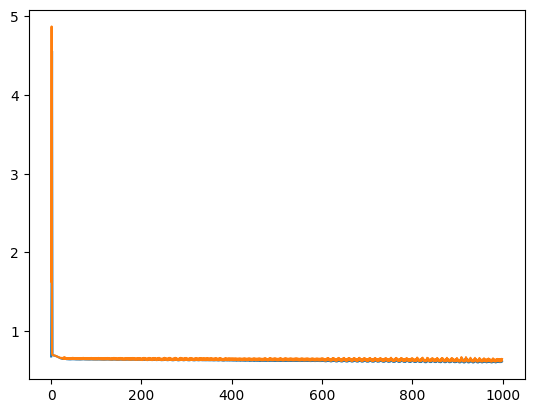

In [55]:
sns.lineplot(train_loss_list)
sns.lineplot(valid_loss_list)

Lets try to improve model 

In [62]:
class MyModel2(torch.nn.Module):
    def __init__(self):
        super(MyModel2, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(11, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
        )
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        x = self.linear_relu_stack(x)
        x = self.sigmoid(x)
        return x.squeeze()

model2 = MyModel2()


In [63]:
NUM_EPOCH = 2000

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1, momentum=0.7)

train_loss_list = []
valid_loss_list = []
accuracy_list = []

min_valid_loss = np.inf

for epoch in range(NUM_EPOCH):
    train_loss = 0.0
    model2.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        pred = model2(inputs)

        loss = loss_fn(pred,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss_list.append(train_loss/len(train_loader))

    model2.eval()
    valid_loss, correct = 0, 0
    size = len(valid_loader.dataset)
    with torch.no_grad():
        for inputs, labels in valid_loader:
            pred = model2(inputs)
            loss = loss_fn(pred,labels)
            valid_loss += loss.item()
            binary_pred = (pred >= 0.5).float()
            correct += (binary_pred==labels).sum().item()

        correct /= size
        valid_loss/=len(valid_loader)

        accuracy_list.append(correct)
        valid_loss_list.append(valid_loss)

        if valid_loss < min_valid_loss:
            min_valid_loss = valid_loss
            best_model = model2
            torch.save(model2, 'best-model.pt')
            torch.save(model2.state_dict(), 'best-model-parameters.pt')

    print(f"Epoch {epoch}: train_loss = {train_loss_list[epoch]}, valid_loss= {valid_loss_list[epoch]}, accuracy= {correct*100}")



Epoch 0: train_loss = 0.7185860276222229, valid_loss= 0.7067301869392395, accuracy= 50.31250000000001
Epoch 1: train_loss = 0.7150040864944458, valid_loss= 0.6934952735900879, accuracy= 50.31250000000001
Epoch 2: train_loss = 0.7100645899772644, valid_loss= 0.6799095869064331, accuracy= 59.375
Epoch 3: train_loss = 0.6971568465232849, valid_loss= 0.6748687028884888, accuracy= 63.4375
Epoch 4: train_loss = 0.6983942985534668, valid_loss= 0.6755560636520386, accuracy= 62.18749999999999
Epoch 5: train_loss = 0.6912628412246704, valid_loss= 0.6750776767730713, accuracy= 61.875
Epoch 6: train_loss = 0.6855766773223877, valid_loss= 0.6744602918624878, accuracy= 62.5
Epoch 7: train_loss = 0.688639223575592, valid_loss= 0.6740574836730957, accuracy= 61.875
Epoch 8: train_loss = 0.6857348680496216, valid_loss= 0.673320472240448, accuracy= 61.875
Epoch 9: train_loss = 0.6934221982955933, valid_loss= 0.6730610728263855, accuracy= 63.125
Epoch 10: train_loss = 0.6906613111495972, valid_loss= 0.673

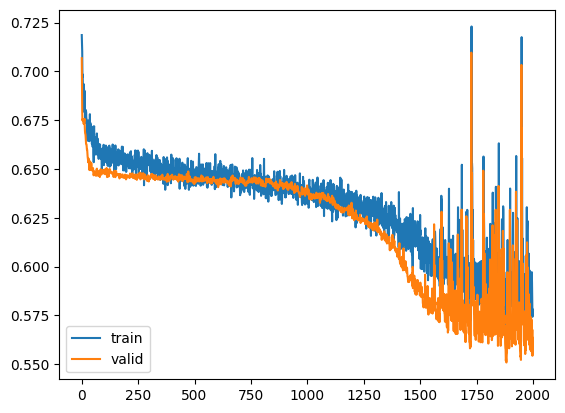

In [64]:
sns.lineplot(train_loss_list, label="train")
sns.lineplot(valid_loss_list, label="valid")
plt.legend()

In [65]:
best_model.state_dict()

OrderedDict([('linear_relu_stack.0.weight',
              tensor([[-0.2830,  0.1957, -0.0081,  ..., -0.0258, -0.0954,  0.0659],
                      [-0.1152,  0.2442, -0.0166,  ..., -0.0026, -0.2242, -0.1237],
                      [-0.0109, -0.3634, -0.0698,  ..., -0.4647,  0.1918,  0.1510],
                      ...,
                      [-0.2202,  0.1945,  0.0955,  ..., -0.2615,  0.1702, -0.2131],
                      [-0.2510, -0.0249,  0.1965,  ...,  0.4044, -0.0166,  0.0779],
                      [-0.0851,  0.2594,  0.0551,  ...,  0.4425, -0.0125,  0.0204]])),
             ('linear_relu_stack.0.bias',
              tensor([ 0.1921, -0.1965,  0.1484, -0.2310,  0.0946,  0.2134, -0.0498,  0.0638,
                      -0.1831, -0.1369,  0.2777, -0.1241, -0.1821, -0.1907, -0.0377, -0.2240,
                       0.1121,  0.1531,  0.2074,  0.0972, -0.2738, -0.0802,  0.0410, -0.0779,
                       0.0885,  0.0010,  0.3402,  0.0684, -0.1931,  0.0494,  0.0184, -0.2270,
    

In [66]:
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score

est_model = MyModel2()
best_model.load_state_dict(torch.load('best-model-parameters.pt'))
best_model.eval()
with torch.no_grad():
    pred = best_model(X_valid)

# Convert pred to a float tensor
pred = (pred > 0.5).to(torch.float)

# Calculate accuracy
accuracy = BinaryAccuracy()
f1_score = BinaryF1Score()
print(f"Accuracy: {accuracy(pred, y_valid)}, f1_score: {f1_score(pred, y_valid)}")

Accuracy: 0.721875011920929, f1_score: 0.7081966996192932


**Conclusions**: My model achieved an accuracy of 72%, wich is not so good. Maybe we need more data or more comlexity model. Compared to ml algorithms for this dataset, my model gives almost the same results